## Dirichlet Mixture Prior for NeuroAlign

#### Problems: 
- The true probability distribution of a column is only poorly estimated by the relative frequencies $\frac{n_i}{n}$ where $n_i$ is the count of amino acid $i$ and $n=\sum_i n_i$, especially if $n$ is small (which is the case when training NeuroAlign due to hardware constraints). 
- If each column predicts its own amino acid distribution, beam search (commonly done in natural language processing) can not be applied when doing autoregressive inference since the output is not expected to agree on a single class (or amino acid).

#### Remedy:

Model the amino acid distribution of each column by a mixture of Dirichlets (Using Dirichlet mixture priors to derive hidden Markov models for protein families, Brown et al., 1993) i.e. a distribution of the form:

$$q_1 P_1 \dots q_k P_k$$

where $P_j$ are Dirichlet densities and $q_j$ are mixture coefficients that sum to 1.

Intuitively this models $k$ "fundamental" amino acid distributions such that an observed count vector of amino acids for a column is very likely obtained from one (or a few) of these distributions. This means we can soft cluster a column to the components of the Dirichlet mixture (i.e. which component(s) are most probably the ground truth of the observed counts). An amino acid count vector can also be converted to a posterior probability distribution over the amino acid alphabet given the counts. 

This framework solves the first problem mentioned above. It also has potential to solve the second one:

Assume NeuroAlign predicts an alignment column given sequences and previously predicted columns, i.e. $P(C_i | S, C_{i-1}, \dots, C_1)$. Especially the prediction of the very first column is crutial. Ideally, to implement something like beam search, we would like to have some candidates for the next column together with probabilities instead of a single prediction of a distribution. Brainstorming:

- Maybe the Dirichlet mixture can be used to soft cluster a predicted column to the components of the mixture. Then the underlying distributions of the $m$ most likely components given the predicted column can provide candidates for a beam search.

- The model could be rewritten such that it predicts a distribution over $k$ instead of the amino acids. This way, the output can be interpreted as a vote for the mixture components. Candidate predictions for a column can be obtained by tracking the $m$ most probable components according to the model.

In [1]:
# uncomment below when using tf 2.3  
import sys
!{sys.executable} -m pip install tensorflow_probability==0.11.0

# uncomment below when using tf 2.4 
#import sys
#!{sys.executable} -m pip install tensorflow_probability

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers

A Dirichlet mixture prior is has (alphabet_size + 1) * $k$ parameters. Each of the $k$ components has one parameter for each symbol in the alphabet and one additional mixture coefficient. 

Thus, let $\mathcal{A}$ be a finite alphabet. Let $\alpha$ be a $k \times |\mathcal{A}|$ matrix and $q$ a vector of length $k$.

Below, we use a pretrained mixture (https://compbio.soe.ucsc.edu/dirichlets/dist.20comp) with $k=20$ components. 

In [2]:
ALPHABET = "A C D E F G H I K L M N P Q R S T V W Y".split()

q = []
alpha = []

k = 20

with open("dirichlet_20comp.txt", "r") as file:
    content = file.readlines()
    for line in content:
        if line[:8] == "Mixture=":
            q.append(float(line[9:]))
        elif line[:6] == "Alpha=":
            alpha.append([float(a) for a in line[7:].split()][1:])

q = np.array(q, dtype=np.float32) 
alpha = np.array(alpha, dtype=np.float32) 

print(q.shape) # k
print(alpha.shape) # k x len(alphabet)

(13,)
(13, 20)


Given a Dirichlet mixture prior, we can implement some useful methods.

Let $c$ be a count vector of a column i.e. $c_i$ is the observed count of the $i$-th amino acid. Let $|c|=\sum_i c_i$.

First we use the implementation of <code>tfp.distributions.DirichletMultinomial</code> to obtain the probability of each count vector given the $k$-th component distribution $P(c \mid P_k, |c|)$, namely the probability of observing $c$ after drawing $|c|$ times from $P_k$.

Then we get posterior component probabilities $P(j\mid c)$ for components $j = 1,\dots,k$ by

$$P(j|c) = \frac{q_j P(c \mid P_j, |c|)}{\sum_l q_l P(c \mid P_l, |c|)} $$

And the posterior amino acid probabilities $\hat{p}_i$ given $c$:

$$\hat{p}_i = \frac{1}{Z} (\sum_{j=1}^k P(j|c) \frac{c_i + \alpha_{j,i}}{|c| + \alpha_j})$$

with $Z$ such that $\sum_i \hat{p}_i = 1$.

Formulas are from the papers "Using Dirichlet mixture priors to derive hidden Markov models for protein families" (Brown et al., 1993) and "Dirichlet mixtures: a method for improveddetection of weak but significant protein sequence homology" (Sjölander et al., 1996). Attention: the latter paper corrected the formula for $\hat{p}_i$ published in the former paper.

In [3]:
class DirichletMixturePrior():
    def __init__(self, q, alpha):
        super(DirichletMixturePrior, self).__init__()
        # Dirichlet parameters > 0
        self.alpha = tf.constant(alpha)
        
        # mixture coefficients that sum to 1
        self.q = tf.constant(q)
        

    # in: n x alphabet_size count vectors 
    # out: n x k posterior probabilty distribution P(k | count)
    def posterior_component_prob(self, counts):
        
        #how many observed amino acids per column
        total_counts = tf.reduce_sum(counts, axis=-1, keepdims=True)
        
        #expand to allow broadcasting to shape n x k x alphabet_size
        alpha = tf.expand_dims(self.alpha,0)
        counts = tf.expand_dims(counts, 1)
        
        #obtain probabilities P(count | p_k) 
        dist = tfp.distributions.DirichletMultinomial(total_counts, alpha)
        probs = dist.prob(counts) #shape n x k
        
        print(probs)
        
        #obtain P(component | count) via P(count | p_k) and the mix coefficients
        mix_probs = tf.expand_dims(self.q,0) * probs
        return mix_probs / tf.reduce_sum(mix_probs, axis=-1, keepdims=True)

    
    # in: n x alphabet_size count vectors 
    #     output of self.posterior_component_prob(count vectors)
    # out: n x alphabet_size posterior amino acid probabilty distributions
    def posterior_amino_acid_prob(self, counts, posterior_component_prob):
        
        counts = tf.expand_dims(counts, 1)
        alpha = tf.expand_dims(self.alpha, 0)
        total_counts = tf.reduce_sum(counts, axis=-1, keepdims=True)
        total_alpha = tf.reduce_sum(alpha, axis=-1, keepdims=True)
        pseudo_counts = (counts + alpha) / (total_counts + total_alpha)
        posterior_component_prob = tf.expand_dims(posterior_component_prob,1)
        #the (batch-)matmul is a marginalization of the component dimension k
        #shape posterior_component_prob : n x 1 x k
        #shape pseudo_counts            : n x k x alphabet_size
        probs_unnormalized = tf.matmul(posterior_component_prob, pseudo_counts) #shape n x 1 x alphabet_size
        Z = tf.reduce_sum(probs_unnormalized, axis=-1, keepdims=True)
        return tf.squeeze(probs_unnormalized / Z) #remove the 1-dimension
    
    
    # out: amino acid distribution of the j's mixture component
    def component_distributions(self):
        return self.alpha / tf.reduce_sum(self.alpha, axis=-1, keepdims=True)


dirichlet_mixture = DirichletMixturePrior(q, alpha)

np.random.seed(33)
tf.random.set_seed(33)

# count vectors from a MSA
n = 7
samples = 30
draws = tf.random.categorical([np.random.dirichlet(alpha[0]) for _ in range(n)], samples)
counts = np.zeros((n, len(ALPHABET)), dtype=np.float32)
for i in range(len(ALPHABET)):
    counts[:,i] = np.sum(draws == i, axis=-1)

posterior_component_prob = dirichlet_mixture.posterior_component_prob(counts)
posterior_amino_acid_prob = dirichlet_mixture.posterior_amino_acid_prob(counts, posterior_component_prob)
component_distributions = dirichlet_mixture.component_distributions()

counts = [[ 32. ,  1. ,  0. ,  0.  , 4.  , 2.  , 1. ,  7. ,  1., 166. ,110. ,  0. , 18. , 88.,
   1.  , 4. , 29. ,  4. ,  9., 219.]]

posterior_component_prob = dirichlet_mixture.posterior_component_prob(counts)
posterior_amino_acid_prob = dirichlet_mixture.posterior_amino_acid_prob(counts, posterior_component_prob)

print(posterior_amino_acid_prob)

tf.Tensor(
[[2.67390937e-26 9.38468877e-28 1.53939796e-25 5.08921435e-25
  2.91164135e-17 4.46045234e-31 5.36978949e-25 0.00000000e+00
  0.00000000e+00 4.85688722e-24 0.00000000e+00 6.72367102e-18
  4.60510283e-29]
 [1.30995134e-28 1.12326436e-27 1.24323612e-27 1.33828404e-25
  3.59984164e-18 2.73441997e-32 4.23364700e-26 0.00000000e+00
  0.00000000e+00 8.44148160e-26 0.00000000e+00 1.01161625e-18
  7.33652475e-25]
 [3.51865293e-25 4.23265976e-27 4.66985836e-25 8.24770485e-24
  6.62676028e-17 4.36774791e-29 1.99861300e-26 8.95519458e-38
  0.00000000e+00 3.87733497e-23 0.00000000e+00 1.42972857e-19
  7.90116323e-28]
 [1.01649735e-27 9.95778906e-30 4.90154527e-29 3.13097414e-26
  3.47181145e-19 1.09622210e-29 6.59009412e-28 0.00000000e+00
  0.00000000e+00 3.22096098e-26 0.00000000e+00 1.96019510e-19
  3.43602039e-30]
 [2.67186608e-29 2.57626112e-29 1.03800999e-27 9.52077998e-27
  3.75130544e-18 8.41829361e-34 7.12564516e-28 0.00000000e+00
  0.00000000e+00 1.23698224e-27 0.00000000e+00 4.

Each component $j$ of the mixture is a Dirichlet distribution with concentrations $\alpha_{j,1}, \dots, \alpha_{j,20} > 0$. Amino acid probabilities are then simply $\frac{\alpha_{j,i}}{\alpha_{j}}$ with $\alpha_{j}=\sum_i \alpha_{j,i}$.

InvalidArgumentError: slice index 9 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

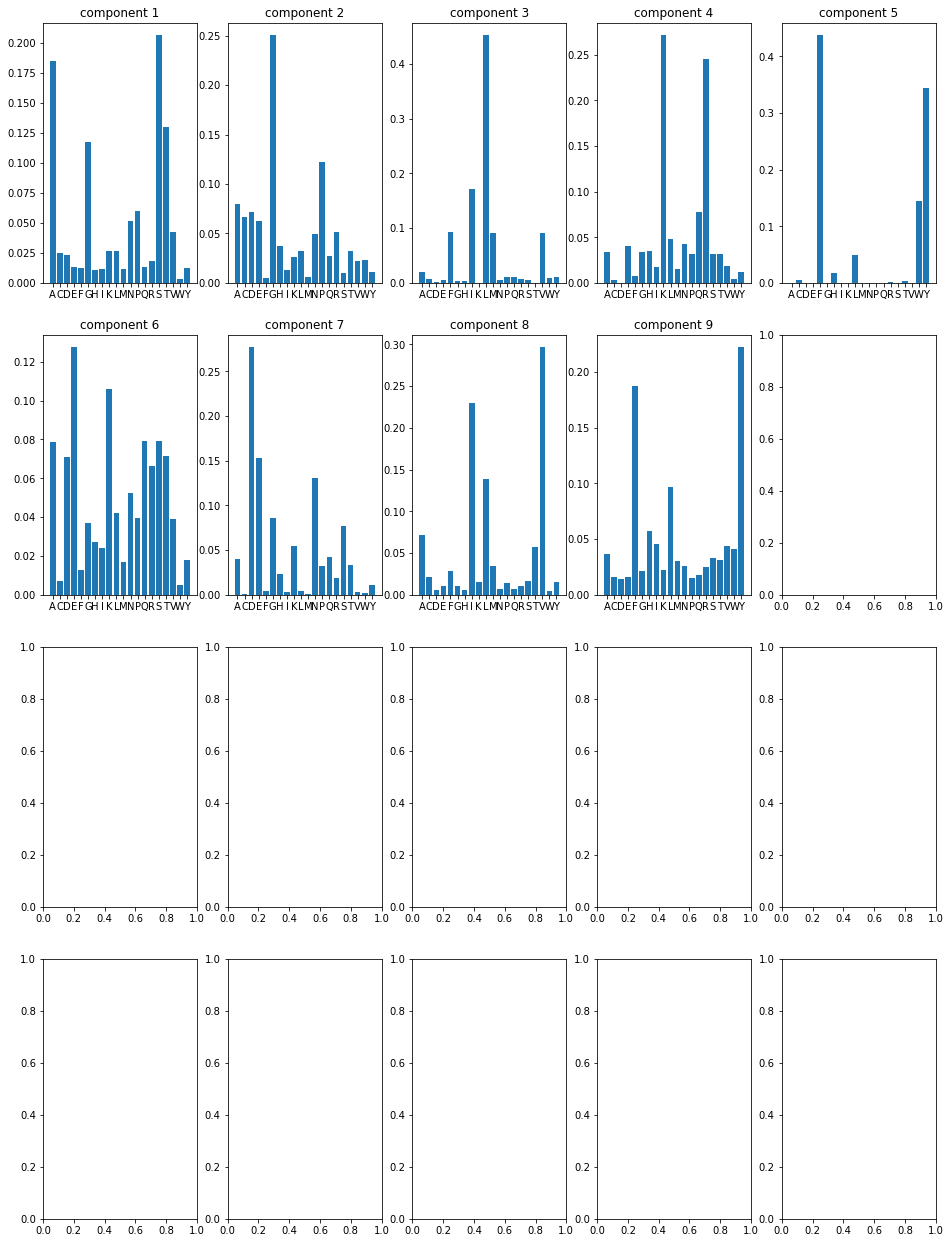

In [4]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 22)

num_rows = 4
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols)
for i,ax in enumerate(axes):
    for j,a in enumerate(ax):
        #a.set_ylim((0,1))
        a.bar(ALPHABET, component_distributions[i*num_cols+j])
        a.set_title("component "+str(i*num_cols+j+1))

plt.show()
#plt.savefig("results/component_distributions.pdf", bbox_inches='tight')

The Dirichlet mixture can be used as a (soft) clustering of observed count vectors to the component distributions. The prior is very certain that the underlying distribution of the count vector below is component 1 (which was in fact used to sample it). This probability increases and decreases with the total count of observed residues (30 in this case) (i.e. the more data, the less influence the prior has).

In [5]:
print("Probabilities that underlying distribution of this count vector")
print(counts[0])
print("with",np.sum(counts[0]), "residues observed")
print("corresponds to the j'th component of the mixture:")
print(posterior_component_prob[0].numpy())

Probabilities that underlying distribution of this count vector
[2. 1. 1. 2. 3. 1. 1. 1. 1. 2. 2. 1. 2. 0. 0. 5. 2. 2. 0. 1.]
with 30.0 residues observed
corresponds to the j'th component of the mixture:
[9.09440219e-01 1.03964489e-02 3.92426045e-05 3.32019578e-10
 6.48063868e-02 2.67434484e-06 0.00000000e+00 7.50442972e-11
 1.50524294e-02 8.38745691e-05 1.14684175e-04 1.92201699e-09
 4.28698655e-14 6.39328719e-05 3.30529142e-13 2.54086552e-09
 4.82630776e-11 1.99802621e-15 9.58445128e-08 3.59431523e-16]


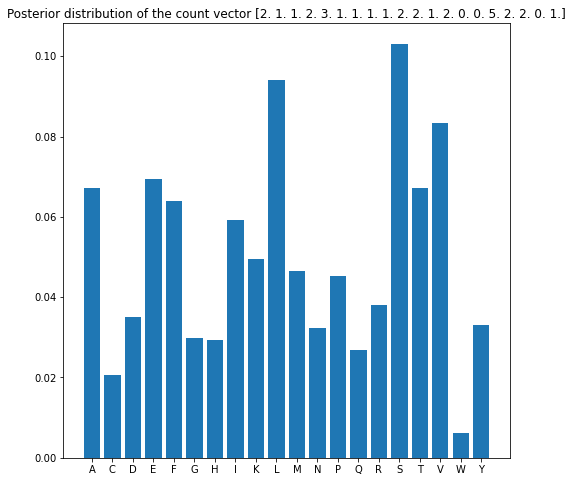

In [6]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.bar(ALPHABET, posterior_amino_acid_prob[0])
plt.title("Posterior distribution of the count vector " + str(counts[0]))
plt.show()

In [5]:
import Data as data
pf3 = data.Fasta("../brain/Pfam/alignments/PF00003.fasta", gaps = True, contains_lower_case = True)


#counts = [ 16., 134. ,  9. ,  0.,  28.,  10. ,  2. ,  1. , 38. , 42.,  32., 210.,  14.,  11.,
#  20.,  12. , 13. , 23. , 32. , 46.]

counts = pf3.column_count_vectors[0]
ALPHABET = ['A', 'R',  'N',  'D',  'C',  'Q',  'E',  'G',  'H', 'I',  'L',  'K',  
            'M',  'F',  'P', 'S',  'T',  'W',  'Y',  'V',  'B',  'Z',  'X', 'U', 'O']

print(counts)

file_alphabet = "A C D E F G H I K L M N P Q R S T V W Y".split()
perm = [ALPHABET.index(aa) for aa in file_alphabet] 
#print(perm)
counts_perm = np.array(counts[:20],dtype=np.float32)[perm]
#print(counts_perm)

dirichlet_mixture.posterior_component_prob(np.expand_dims(counts_perm,0))

for c,a,d,p in zip(counts_perm, 
                   file_alphabet, 
                   dirichlet_mixture.alpha[0], 
                   dirichlet_mixture.component_distributions()[0]):
    print(c,a,d.numpy(),p)
    
dist = tfp.distributions.DirichletMultinomial(np.sum(counts_perm,-1), dirichlet_mixture.alpha[0])
dist.prob(counts_perm)

[ 72.   0.   0.   0.   6.   1.   0.   4.   0. 167.  87.   0.  30.  52.
   0.  79.   8.   1.   1.  64.   0.   0.   0.   0.   0.]
tf.Tensor(
[[1.4274842e-33 1.1644311e-31 6.5140794e-38 3.8526139e-36 1.0905045e-28
  3.0081620e-31 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.1386375e-33
  1.4952393e-38 3.4968242e-35 5.4718080e-35]], shape=(1, 13), dtype=float32)
72.0 A 0.388746 tf.Tensor(0.29851678, shape=(), dtype=float32)
6.0 C 0.0367385 tf.Tensor(0.028211374, shape=(), dtype=float32)
0.0 D 0.026518 tf.Tensor(0.020363085, shape=(), dtype=float32)
0.0 E 0.0322076 tf.Tensor(0.024732111, shape=(), dtype=float32)
52.0 F 0.0137612 tf.Tensor(0.01056718, shape=(), dtype=float32)
4.0 G 0.206244 tf.Tensor(0.15837409, shape=(), dtype=float32)
0.0 H 0.0059514 tf.Tensor(0.0045700604, shape=(), dtype=float32)
167.0 I 0.0158113 tf.Tensor(0.012141445, shape=(), dtype=float32)
0.0 K 0.0351076 tf.Tensor(0.026959011, shape=(), dtype=float32)
87.0 L 0.0350778 tf.Tensor(0.026936127, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=1.4274842e-33>